# Installs and Imports

In [1]:
from evaluate_utils import *
import pandas as pd
import os
def get_merged_df(human_df, machine_df, filepath, relable=False, test=False):
  if os.path.exists(filepath):
    merged_df = pd.read_csv(filepath)
    # check if merged_df has any unnamed columns, that just replicate the old index
    for col in merged_df.columns:
      if col.startswith("Unnamed"):
        merged_df = merged_df.drop(col, axis=1)
        merged_df.to_csv(filepath, index=False)
  else:
    merged_df = machine_df.merge(human_df, on=["letter_id", "n_footnote"])
    merged_df = merged_df[["letter_id", "n_footnote", "generated_footnote", "xml_footnote", "label"]]
    merged_df.to_csv(filepath, index=False)
  return merged_df

# since I redid the labeling, also initially these dfs did not have the labels...
def relabel(human_df, filepath, test=True):
  merged_df = pd.read_csv(filepath)
  # take out the old label column from merged df if it exists
  if "label" in merged_df.columns:
    merged_df = merged_df.drop("label", axis=1)
  label_df = human_df[["letter_id", "n_footnote", "label"]].copy()
  merged_df = merged_df.merge(label_df[["letter_id", "n_footnote", "label"]], on=["letter_id", "n_footnote"])

  if test:  # test before I screw up my data...
    return merged_df
  else:
    merged_df.to_csv(filepath, index=False)
    print(f"realbled {filepath}")


pd.set_option('display.max_colwidth', None)

/home/niko/anaconda3/envs/sacrebleu-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

DATA_DIR = "../../data"
human_footnotes_df = pd.read_csv(os.path.join(DATA_DIR, "footnote_downsized_df_new.csv"))
human_footnotes_df["xml_footnote"] = human_footnotes_df["xml_footnote"].apply(remove_outer_note_tag)

In [5]:
model_name_map = {
    "llama-8B": "Meta-Llama-3.1-8B-Instruct",
    "llama-70B": "Meta-Llama-3.1-70B-Instruct-bnb-4bit",
    "llama-8B-add-example": "bullingerLM_llama-3.1-8B-Instruct_example",
    "llama-8B-add": "BullingerDigitalLMFootnotes_instruct-add",
    "llama-8B-qa": "BullingerDigitalLMFootnotes_llama_instruct_qa",
    "llama-8B-qa-add": "BullingerDigitalLMFootnotes_llama_instruct_qa_add",
    "llama-8B-bible": "llama-3.1-8B-instruct-bible",
    "llama-8B-EA": "llama3.1-8B-instruct-EA",
    "Qwen-7B-instruct": "Qwen2.5-7B-Instruct",
    "gpt-4o-mini": "gpt-4o-mini-2024-07-18",
    "gpt-4o": "gpt-4o-2024-08-06"
}

EVAL_FOLDER = os.path.join(DATA_DIR, "evaluation_1/")

import os
import pandas as pd

def average(df):
    """
    Compute the mean and standard deviation for each column in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with evaluation metrics.
    
    Returns:
        tuple: Two lists, one with averages and one with standard deviations.
    """
    columns = ["bleu_without", "rouge_without", "bert_without", "bleu_with", "rouge_with", "bert_with"]
    averages = []
    stds = []
    for col in columns:
        scaled_data = df[col] * 100  # Scale data to percentages
        averages.append(scaled_data.mean())  # Compute mean
        stds.append(scaled_data.std())      # Compute standard deviation
    return averages, stds

def compare(models: list, split: str, prompt):
    """
    Compare models by computing the mean and standard deviation for each metric.
    
    Parameters:
        models (list): List of model names to compare.
        split (str): Data split identifier (e.g., "test").
        prompt (str): Prompt identifier.
    
    Returns:
        tuple: DataFrames with averages and standard deviations.
    """
    columns = ["bleu_without", "rouge_without", "bert_without", "bleu_with", "rouge_with", "bert_with"]
    results_avg = {}
    results_std = {}
    for model in models:
        filename = f"evaluation-{model}_{prompt.replace('_', '-')}_{split.replace('_', '-')}.csv"
        filepath = os.path.join(EVAL_FOLDER, filename)
        if not os.path.exists(filepath):
            print(f"No evaluation yet for {model} on {prompt}, {split}")
            continue
        df = pd.read_csv(filepath)
        averages, stds = average(df)
        results_avg[model] = averages
        results_std[model] = stds

    avg_df = pd.DataFrame(columns=columns)
    std_df = pd.DataFrame(columns=columns)
    for model in results_avg:
        avg_df.loc[model] = results_avg[model]
        std_df.loc[model] = results_std[model]
    return avg_df, std_df


# find missing experiments:
def find_missing_experiments(models, splits, prompts):
# go through all combinations of splits, prompts and models
  for split in splits:
    for prompt in prompts:
      for model in models:
        filename = f"evaluation-{model_name_map[model]}_{prompt}_{split}.csv"
        filepath = os.path.join(EVAL_FOLDER, filename)
        if not os.path.exists(filepath):
          print(f"No evaluation yet for {model} on {prompt}, {split}")

# evaluation-Meta-Llama-3.1-8B-Instruct_instruct_add_test.csv

In [7]:
# run over all files in the evaluate folder, and relabel
# This was done because I redid the classification, but did not want to redo the sampling, and generating
if False:
  for filename in os.listdir(EVAL_FOLDER):
    if filename.endswith(".csv"):
      merged_df = pd.read_csv(os.path.join(EVAL_FOLDER, filename))
      relabel(human_footnotes_df, os.path.join(EVAL_FOLDER, filename), test=False)

#

In [15]:
splits = ["example"]
prompts = ["instruct_add", "instruct_qa"]
models = model_name_map.keys()
find_missing_experiments(models, splits, prompts)

No evaluation yet for llama-8B on instruct_add, example
No evaluation yet for llama-70B on instruct_add, example
No evaluation yet for llama-8B-add-example on instruct_add, example
No evaluation yet for llama-8B-add on instruct_add, example
No evaluation yet for llama-8B-qa on instruct_add, example
No evaluation yet for llama-8B-qa-add on instruct_add, example
No evaluation yet for llama-8B-bible on instruct_add, example
No evaluation yet for llama-8B-EA on instruct_add, example
No evaluation yet for Qwen-7B-instruct on instruct_add, example
No evaluation yet for gpt-4o-mini on instruct_add, example
No evaluation yet for gpt-4o on instruct_add, example
No evaluation yet for llama-8B on instruct_qa, example
No evaluation yet for llama-70B on instruct_qa, example
No evaluation yet for llama-8B-add-example on instruct_qa, example
No evaluation yet for llama-8B-add on instruct_qa, example
No evaluation yet for llama-8B-qa on instruct_qa, example
No evaluation yet for llama-8B-qa-add on ins

# Evaluate Llama models

In [10]:
SPLIT = "dev_100"
PROMPT = "instruct_qa"
MODEL_NAME = "llama-8B-zwa"

In [11]:
df_filename = f"{MODEL_NAME}_{PROMPT.replace('_','-')}_{SPLIT.replace('_','-')}.csv"
generated_footnotes_df = pd.read_csv(os.path.join(DATA_DIR, f"model_responses/llama/{df_filename}"))
eval_df_filename = f"evaluation-{MODEL_NAME}_{PROMPT.replace('_','-')}_{SPLIT.replace('_','-')}.csv"
eval_df_filepath = os.path.join(EVAL_FOLDER, eval_df_filename)
merged_df = get_merged_df(human_footnotes_df, generated_footnotes_df, eval_df_filepath)
evaluator = genEvaluator(merged_df, batch_size=2)

bert_with is missing
bert_without is missing
No BLEU and ROUGE with markup are missing
No BLEU and ROUGE without are missing


In [8]:
merged_df[merged_df["generated_footnote"].str.contains("b")]

,letter_id,n_footnote,generated_footnote,xml_footnote,label,bleu_with,rouge_with,bleu_without,rouge_without
1,11406,3,"Die Verbote in den ersten Evangelien, die wiederholt wurden, betrafen wahrscheinlich die Beziehungen zwischen Juden und Nichtjuden.","Die wiederholten Verbote richteten sich gegen Schmachlieder, Gotteslästerung, Zutrinken, Masken und Tanz; vgl. <bibl>ABaslerRef</bibl> II 291; VI 243.",misc,0.027386,0.153846,0.033449,0.166667
2,11086,11,"Jakob Geßner, Bruder von Heinrich Bullinger, spielte eine wichtige Rolle bei der Abrechnung am 23. Juli, indem er als Informant und Zeuge zur Verfügung stand.","Wohl <persName ref=""p4951"" cert=""high"">Jakob Geßner</persName>, der auch am 23. Juli der Abrechnung beigewohnt hatte (vgl. oben Anm. 8).",misc,0.078594,0.357143,0.078594,0.384615
3,12870,115,"Bullingers Commentarius in Acta apostolorum, Tiguri 1537 (HBBibl 1, Nr. 108), und die Ausgabe von 1538 (HBBibl 1, Nr. 109).","Gemeint ist eine der Ausgaben von <hi>Bullinger,</hi> Commentarius in Acta apostolorum, Zürich 1533, 1535 oder 1540 <hi>(HBBib I</hi> I 43-45).",misc,0.085751,0.285714,0.161886,0.322581
6,12310,19,"Über den Tod von <persName ref=""18443"" type=""auto_name"">Karl II. von Orléans</persName> (gest. 1385) ist bekannt, dass er durch Gift getötet wurde, vgl. zuletzt oben <ref target=""file12307"">Nr. 2260</ref>, 15-16.","Zum Tod von <persName ref=""p18443"" cert=""high"">Charles II. von Orléans</persName> am 9. September s. oben <ref target=""file12307"">Nr. 2260</ref>, Anm. 17.",misc,0.249878,0.540541,0.112038,0.413793
9,11553,4,"<note xml:id=""fn4"" type=""footnote"" n=""4"">Pest ist das heutige Budapest, die Hauptstadt Ungarns. Der Kampf um die Stadt war in diesem Jahr besonders intensiv. Der Sultan selbst, <persName ref=""p4079"" cert=""high"">Suleiman der Prächtige</persName>, war anwesend, starb aber am 6. September 1526. Die Eroberung der Stadt durch die Osmanen markierte den Beginn der türkischen Herrschaft in Ungarn, die bis ins 17. Jahrhundert andauern sollte. Vgl. dazu den Brief von <persName ref=""p4079"" cert=""high"">Zwicks</persName> an <persName ref=""p4079"" cert=""high"">Bullinger</persName> vom 4. Oktober 1526 (Zürich StA, E II 336, 137).<pb type=""edition"" next=""176""/></note>","<placeName ref=""l1841"" cert=""high"">Pest</placeName> (vgl. oben <ref target=""file11530"">Nr. 1487</ref>, Anm. 2).",misc,0.008496,0.064516,0.010385,0.081633
...,...,...,...,...,...,...,...,...,...
92,12682,16,"Das kaiserliche Heer zog weiter, nachdem es sich am 24. August 1547 bei Mühlhausen vereinigt hatte.","Vgl. <ref target=""file12659"">Nr. 2612</ref>,121-126 und Anm. 104. - Das kaiserliche Heer zog erst am 31. Oktober weiter; s. <bibl>Schüz, Donaufeldzug</bibl> 70, Skizze 7.",misc,0.037460,0.187500,0.058423,0.214286
94,12332,32,Dompfaffen (Domprobst) bezeichnet im historischen Kontext den Leiter einer Domkirche oder eines Domkapitels.,"""Dompfaffen"": abschätzig für Chorherren. - Listen gefangener Adliger werden in <bibl>PA</bibl> I 482, <ref target=""file10806"">Nr. 768</ref>, angeführt.",misc,0.020316,0.083333,0.033495,0.100000
98,12312,17,"Zwei Briefe, die am 6. und 8. Mai (s. unten <hi>Z. 10-23</hi>) verfasst worden waren; vgl. oben <ref target=""file12108"">Nr. 2061</ref>, Anm. 9.","Es sind wohl Briefe gemeint, die für die sich in Zürich aufhaltenden <placeName ref=""l16"" cert=""high"">Italiener</placeName> bestimmt waren.",misc,0.017272,0.064516,0.021477,0.080000
99,12419,8,"Vgl. <bibl><author>Abun-Nasr</author>, <title>History of the Maghrib</title>, 145–148; <bibl><author>Brunschvig</author>, <title>Encyclopaedia of Islam</title>, Bd. 1, 134f. s.v. <hi>al-Ḥafṣid</hi>; <bibl><author>Brett</author>, <title>The Fatimid and Ayyubid Caliphs</title>, 144–146; <bibl><author>Brett</author>, <title>The Dynasty of the Hafsids</title>, 17–19.","<persName ref=""p18419"" cert=""high"">Achmed III.</persName>, Kalif aus der Dynastie der <persName ref=""p20057"" cert=""high"">Hafsiden</persName> bis 1570; s. <bib

In [ ]:
merged_df["label"].unique()

array(['misc', 'missing', 'inner_ref', 'self_ref', 'bible', 'short',
       'bibl', 'inner_ref, lex', 'self_ref, missing', 'bible, bibl',
       'self_ref, bible'], dtype=object)

In [12]:
# no GPU
evaluator.compute_bleu_rouge()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filepath, index=False)

calculating BLEU and ROUGE with markup


100%|██████████| 101/101 [00:00<00:00, 308.17it/s]


calculating BLEU and ROUGE without markup


100%|██████████| 101/101 [00:00<00:00, 273.97it/s]


In [13]:
# with GPU
evaluator.compute_bertscore()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filepath, index=False)

Computing BERT with Mark-Up


100%|██████████| 101/101 [01:08<00:00,  1.48it/s]


Computing BERT without Markup


100%|██████████| 101/101 [00:45<00:00,  2.24it/s]


# Evaluate GPT 4o-mini generation
Note that for the filename creation here, '-' is used instead of '_'<br>
Is this optimal? No! but too late to change...

In [68]:
SPLIT = "test"
PROMPT = "instruct_add"
MODEL_NAME = "gpt-4o-mini"

In [69]:
df_filename = f"{model_name_map[MODEL_NAME]}-{PROMPT}-{SPLIT}.csv"
generated_footnotes_df = pd.read_csv(f"../../data/model_responses/gpt/{df_filename}")
eval_df_filename = f"evaluation-{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
eval_df_filepath = os.path.join(EVAL_FOLDER, eval_df_filename)
merged_df = get_merged_df(human_footnotes_df, generated_footnotes_df, os.path.join(EVAL_FOLDER, eval_df_filename))
evaluator = genEvaluator(merged_df)

bert_with is missing
bert_without is missing
No BLEU and ROUGE with markup are missing
No BLEU and ROUGE without are missing


In [72]:
merged_df

,letter_id,n_footnote,generated_footnote,xml_footnote,label,bleu_with,rouge_with,bleu_without,rouge_without
0,10038,10,"Die Frage, warum Christus nicht sofort nach seiner ersten Verheißung auf Erden erschienen ist, reflektiert eine theologische Debatte über das Wesen des göttlichen Plans und die Zeitlichkeit der Erlösung. In der christlichen Tradition wird häufig auf die Notwendigkeit verwiesen, dass das Kommen Christi in die Welt einen bestimmten göttlichen Zeitrahmen erfordert, der das Verständnis des Menschen überschreitet. Die erwähnten prophetischen Voraussagen bieten einen weiteren Kontext, um die Diskrepanz zwischen irdischem Leiden und göttlicher Erfüllung in der Heilsgeschichte zu interpretieren. Betrachtet man die Schriften des Neuen Testaments, insbesondere die Evangelien, wird deutlich, dass die zeitliche Offenbarung des Christus immer in Verbindung mit dem göttlichen Willen und dem Heilsplan steht.","<persName ref=""p18700"" cert=""high"">Augustin</persName>, ep. XCIII, 35 (<bibl>CSEL</bibl> XXXIIII 480, 9ff), u. ö.",misc,0.000000,0.000000,0.000000,0.000000
1,10038,11,"Der Hinweis auf Mose bezieht sich auf dessen Rolle als Prophet und Führer des Volkes Israel, das aus der ägyptischen Sklaverei befreit wurde. Die Referenz zu den Propheten kann auch die Erwartungen der Reformatoren widerspiegeln, die die Rückkehr zu einer ersten, unverdorbenen Form der Glaubensausübung forderten. Sie beziehen sich auf das biblische Verständnis von Offenbarung, das den Propheten (Mose und Paulus) als Vorbilder im Glauben sieht und deren Autorität zur Interpretation des göttlichen Willens betont.","Vgl. <cit type=""bible""><ref>Dtn 18,15ff</ref></cit>.",bible,0.000000,0.000000,0.000000,0.000000
2,10038,12,"Die Frage nach dem Plan Gottes wird oft in der Theologie diskutiert. Bullinger deutet hier an, dass die Vorgaben der göttlichen Vorsehung und die Art und Weise, wie sie sich im Lauf der Geschichte entfalten, einen bestimmten Zweck haben, der oft schwer zu verstehen ist. So lässt sich auf Johannes Chrysostomus verweisen, der in seinen Schriften darauf hinweist, dass die Notwendigkeit des göttlichen Willens nicht immer für den Menschen erkennbar ist (vgl. ""In Matthaeum"", Homilie 19).","Vgl. <cit type=""bible""><ref>1 Kor 12, 10.28</ref></cit>; <cit type=""bible""><ref>14,3ff</ref></cit>, u. ö.",bible,0.009691,0.035714,0.009691,0.041667
3,10038,13,"In Anlehnung an die biblische Tradition spricht Bullinger hier die Idee an, dass die Propheten ""befreit"" wurden, um den Willen Gottes zu offenbaren und die Menschen auf den richtigen Weg zu führen. Der Verweis auf die ""deploratissimi"" Zustand der Menschen unter dem ""impiissimo Antichristi regno"" könnte auf die allgemeine Unzufriedenheit mit der religiösen Situation seiner Zeit hinweisen, insbesondere im Kontext der Reformation, bei der die Autorität der Kirche hinterfragt wurde. Bullinger drückt damit den Wunsch aus, die göttliche Wahrheit in einer Zeit der Verwirrung wiederherzustellen und die Menschen zu motivieren, Gott und seiner Botschaft treu zu bleiben.","<cit type=""bible""><ref>1 Joh 4,1</ref></cit>.",bible,0.000000,0.000000,0.000000,0.000000
4,10038,14,"Die Betonung der göttlichen Inspiration und der prophetischen Freiheit, die im neuen Testament gefördert wird, zeigt sich besonders in <persName ref=""p1043"" cert=""high"">Johannes</persName> 1, 4-10 und <persName ref=""p18700"" cert=""high"">Paulus</persName> in seinem ersten Brief an die Thessalonicher 5, 20-21, wo das Prüfen aller Geister gefordert wird.<note xml:id=""fn14"" type=""footnote"" n=""14""></note>","<cit type=""bible""><ref>1 Thess 5,19-20</ref></cit>.",bible,0.016339,0.153846,0.020706,0.206897
...,...,...,...,...,...,...,...,...,...
3234,13141,41,"<note xml:id=""fn41"" type=""footnote"" n=""41"">Die Stadt Madenburg (heute Magdeburg) spielte während der Reformationszeit eine bedeutende Rolle, insbesondere als ein Zentrum reformatorischer Aktivitäten und als Stätte des Konflikts zwischen reformierten und luthe

In [70]:
# no GPU
evaluator.compute_bleu_rouge()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filepath, index=False)

calculating BLEU and ROUGE with markup


100%|██████████| 3239/3239 [00:02<00:00, 1541.65it/s]

calculating BLEU and ROUGE without markup



100%|██████████| 3239/3239 [00:02<00:00, 1369.66it/s]


In [17]:
# with GPU
evaluator.compute_bertscore()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filepath, index=False)

Computing BERT with Mark-Up


  0%|          | 0/94 [00:01<?, ?it/s]


KeyboardInterrupt: 

# Correlation of Evaluators

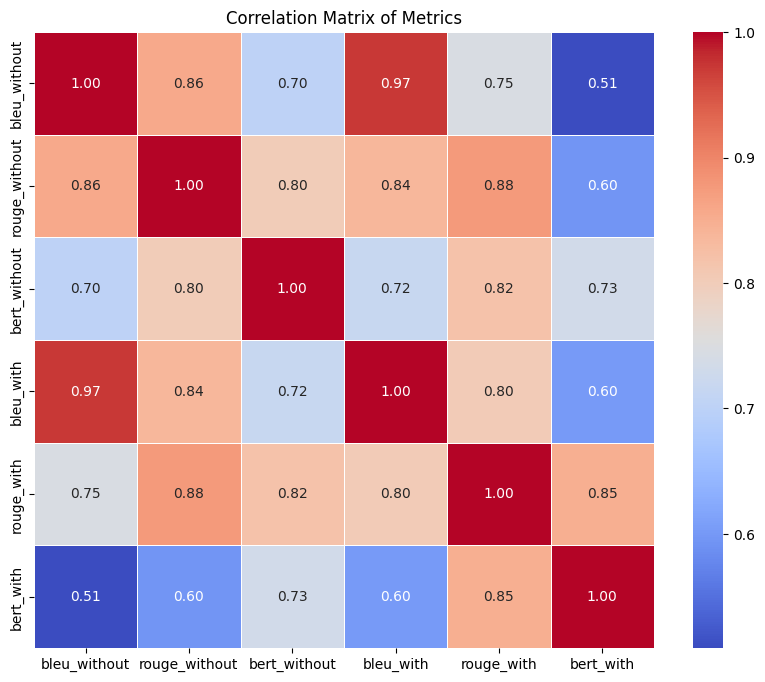

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the correlation matrix
correlation_matrix = merged_df[['bleu_without', 'rouge_without',  "bert_without",  "bleu_with", "rouge_with", "bert_with"]].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Display the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Metrics')
plt.show()

# Comparing models

In [15]:
def df_to_latex_table(df):
    """
    Converts a pandas DataFrame into a LaTeX table with "With" and "Without" under metrics.
    Bold and italic formatting for highest and second-highest values in each column.

    Parameters:
        df (pd.DataFrame): DataFrame containing the metrics.

    Returns:
        str: A LaTeX table as a string.
    """
    # Define metrics and prepare table structure
    metrics = ["BLEU", "ROUGE", "BERT"]
    latex_table = "\\begin{tabular}{lcccccc}\n"
    latex_table += "\\toprule\n"
    latex_table += "Model & \\multicolumn{2}{c}{BLEU} & \\multicolumn{2}{c}{ROUGE} & \\multicolumn{2}{c}{BERT} \\\\\n"
    latex_table += "\\cmidrule(lr){2-3} \\cmidrule(lr){4-5} \\cmidrule(lr){6-7}\n"
    latex_table += "& {Without} & {With} & {Without} & {With} & {Without} & {With} \\\\\n"
    latex_table += "\\midrule\n"

    # Iterate over rows in the DataFrame
    for model, values in df.iterrows():
        row = f"{model.replace('_', '-')} "
        for metric in ["bleu", "rouge", "bert"]:
            without = values[f"{metric}_without"]
            with_markup = values[f"{metric}_with"]

            # Determine formatting for "Without"
            max_without = df[f"{metric}_without"].max()
            second_max_without = df[f"{metric}_without"].nlargest(2).iloc[-1]
            if without == max_without:
                without = f"\\textbf{{{without}}}"
            elif without == second_max_without:
                without = f"\\textit{{{without}}}"

            # Determine formatting for "With"
            max_with = df[f"{metric}_with"].max()
            second_max_with = df[f"{metric}_with"].nlargest(2).iloc[-1]
            if with_markup == max_with:
                with_markup = f"\\textbf{{{with_markup}}}"
            elif with_markup == second_max_with:
                with_markup = f"\\textit{{{with_markup}}}"

            # Append formatted values to the row
            row += f"& {without} & {with_markup} "

        row += "\\\\\n"
        latex_table += row

    # Finalize the table structure
    latex_table += "\\bottomrule\n"
    latex_table += "\\end{tabular}\n"
    latex_table += "Bolded values are the highest in each column, and italicized values are the second-highest.}\n"
    latex_table += "\\label{tab:results}\n"

    return latex_table

In [12]:
print(df_to_latex_table(mean_df.round(2)))

\begin{tabular}{lcccccc}
\toprule
Model & \multicolumn{2}{c}{BLEU} & \multicolumn{2}{c}{ROUGE} & \multicolumn{2}{c}{BERT} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(lr){6-7}
& {Without} & {With} & {Without} & {With} & {Without} & {With} \\
\midrule
llama-8B-base & 2.18 & 2.72 & 6.78 & 8.96 & 62.68 & 61.92 \\
llama-8B-add & \textit{4.12} & \textit{5.55} & \textit{12.99} & \textit{19.47} & \textit{68.4} & \textit{70.61} \\
llama-8B-add-qa & 3.41 & 4.92 & 10.73 & 17.53 & 67.05 & 69.26 \\
llama-70B-base & 3.05 & 3.83 & 9.39 & 12.74 & 64.86 & 64.48 \\
llama-70B-add & \textbf{7.45} & \textbf{9.21} & \textbf{18.76} & \textbf{26.29} & \textbf{70.95} & \textbf{73.18} \\
\bottomrule
\end{tabular}
\caption{Comparison of BLEU, ROUGE, and BERT scores with and without enhancements. Bolded values are the highest in each column, and italicized values are the second-highest.}
\label{tab:results}



In [9]:
mean_df, std_df = compare(["llama-8B-base", "llama-8B-add",  "llama-8B-add-qa", "llama-70B-base", "llama-70B-add"], "dev_100", "instruct_add")
mean_df.round(2)

,bleu_without,rouge_without,bert_without,bleu_with,rouge_with,bert_with
llama-8B-base,2.18,6.78,62.68,2.72,8.96,61.92
llama-8B-add,4.12,12.99,68.40,5.55,19.47,70.61
llama-8B-add-qa,3.41,10.73,67.05,4.92,17.53,69.26
llama-70B-base,3.05,9.39,64.86,3.83,12.74,64.48
llama-70B-add,7.45,18.76,70.95,9.21,26.29,73.18


In [59]:
mean_df, std_df = compare(["llama-70B-base", "llama-70B-add"], "dev_100", "instruct_add")
mean_df

,bleu_without,rouge_without,bert_without,bleu_with,rouge_with,bert_with
llama-70B-base,3.051897,9.393874,64.860337,3.832269,12.741946,64.475277
llama-70B-add,7.448465,18.757611,70.948920,9.214639,26.289998,73.180175


In [46]:
mean_df

,bleu_without,rouge_without,bert_without,bleu_with,rouge_with,bert_with
llama-70B-base,3.051897,9.393874,64.860337,3.832269,12.741946,64.475277
llama-70B-add,7.448465,18.757611,70.948920,9.214639,26.289998,73.180175


In [ ]:
mean_df, std_df = compare(["llama-8B-base", "llama-8B-qa", "llama-8B-Zwa", "llama-8B-qa-Zwa"], "dev_100", "instruct_qa")
mean_df

,bleu_without,rouge_without,bert_without,bleu_with,rouge_with,bert_with
llama-8B-base,5.782183,18.518395,66.587100,5.781814,19.449786,65.522094
llama-8B-qa,22.083219,43.427592,79.481144,27.068524,50.364962,81.861061
llama-8B-Zwa,3.610352,14.141658,64.804072,3.352344,14.907087,62.818331
llama-8B-qa-Zwa,1.178573,6.313242,59.250212,2.419309,10.813420,62.956313


In [16]:
print(df_to_latex_table(mean_df.round(2)))

\begin{tabular}{lcccccc}
\toprule
Model & \multicolumn{2}{c}{BLEU} & \multicolumn{2}{c}{ROUGE} & \multicolumn{2}{c}{BERT} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(lr){6-7}
& {Without} & {With} & {Without} & {With} & {Without} & {With} \\
\midrule
llama-8B-base & 5.78 & 5.78 & 18.52 & 19.45 & 66.59 & 65.52 \\
llama-8B-qa & \textit{22.08} & \textit{27.07} & \textit{43.43} & \textit{50.36} & \textit{79.48} & \textit{81.86} \\
llama-8B-Zwa & 3.61 & 3.35 & 14.14 & 14.91 & 64.8 & 62.82 \\
llama-70B-base & 8.21 & 7.04 & 25.41 & 24.29 & 70.12 & 66.94 \\
llama-70B-qa & \textbf{25.11} & \textbf{29.56} & \textbf{47.24} & \textbf{53.23} & \textbf{81.21} & \textbf{82.86} \\
llama-70B-zwa & 7.87 & 5.53 & 23.31 & 20.2 & 70.8 & 66.06 \\
\bottomrule
\end{tabular}
Bolded values are the highest in each column, and italicized values are the second-highest.}
\label{tab:results}



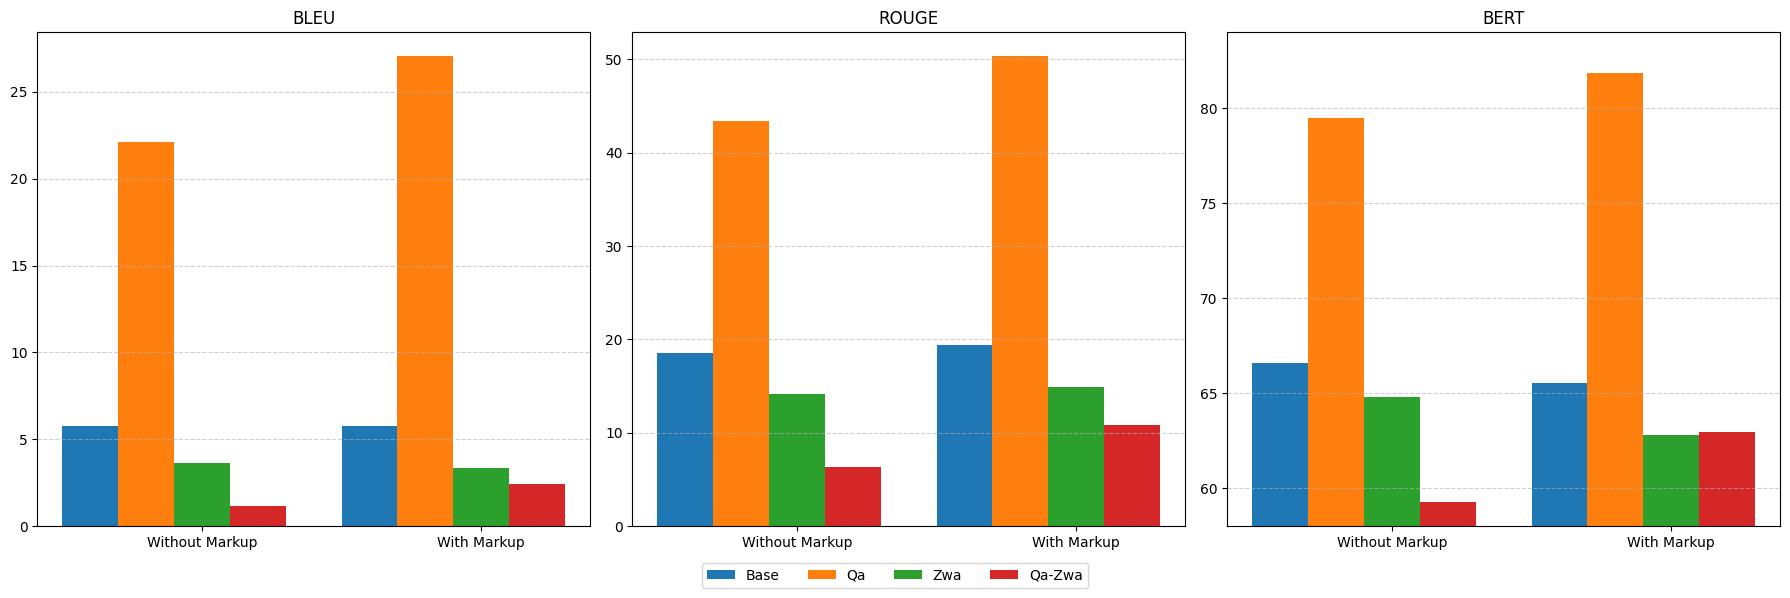

In [23]:
from eval_plots import plot_model_metrics_with_ci
import matplotlib.pyplot as plt


plot_model_metrics_with_ci(mean_df, "8B", bert_ylim=(58, 84))
if True:
    plot_folder = os.path.abspath(r"/mnt/c/Users/nik_b/Documents/UZH/CL/Master_thesis_text/master-thesis/images/plots")
    # plot_folder = "../plots"
    plot_name = "8B-dev100.pdf"
    plt.savefig(os.path.join(plot_folder, plot_name), dpi=300, bbox_inches='tight',format='pdf')

In [24]:
mean_df, std_df = compare(["llama-70B-base", "llama-70B-qa", "llama-70B-Zwa", "llama-70B-qa-Zwa"], "dev_100", "instruct_qa")
mean_df

,bleu_without,rouge_without,bert_without,bleu_with,rouge_with,bert_with
llama-70B-base,8.213830,25.412032,70.116626,7.035778,24.291953,66.936217
llama-70B-qa,25.113171,47.240169,81.210925,29.561733,53.231854,82.857362
llama-70B-Zwa,7.865516,23.307174,70.800906,5.528967,20.202854,66.061785
llama-70B-qa-Zwa,17.097783,36.119823,75.726631,20.675833,41.979701,77.794332


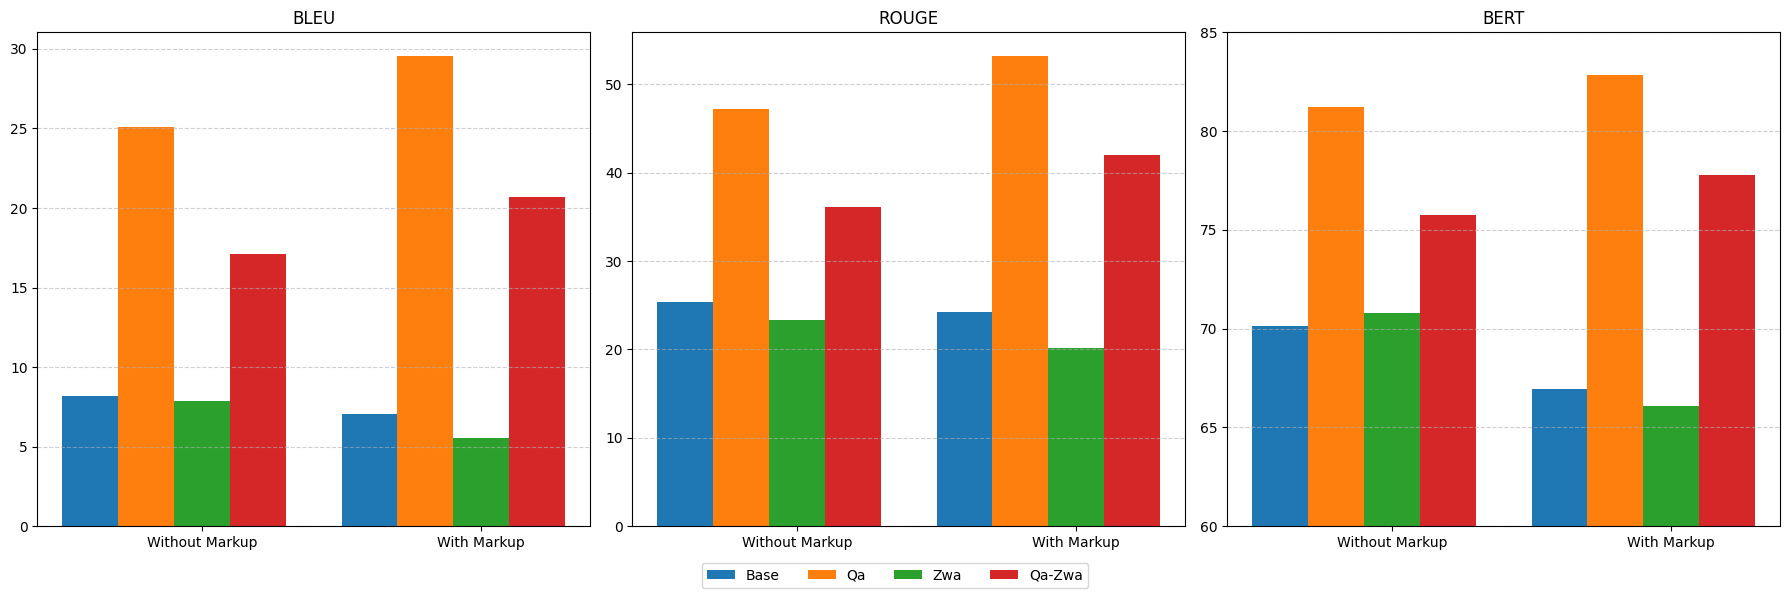

In [25]:
plot_model_metrics_with_ci(mean_df, "70B", bert_ylim=(60, 85))
if True:
    plot_folder = os.path.abspath(r"/mnt/c/Users/nik_b/Documents/UZH/CL/Master_thesis_text/master-thesis/images/plots")
    # plot_folder = "../plots"
    plot_name = "70B-dev100.pdf"
    plt.savefig(os.path.join(plot_folder, plot_name), dpi=300, bbox_inches='tight',format='pdf')

In [78]:
mean_df, std_df = compare(["llama-8B-base", "llama-8B-qa", "llama-8B-qa-add", "llama-70B-base", "llama-70B-qa"], "dev_100", "instruct_qa")

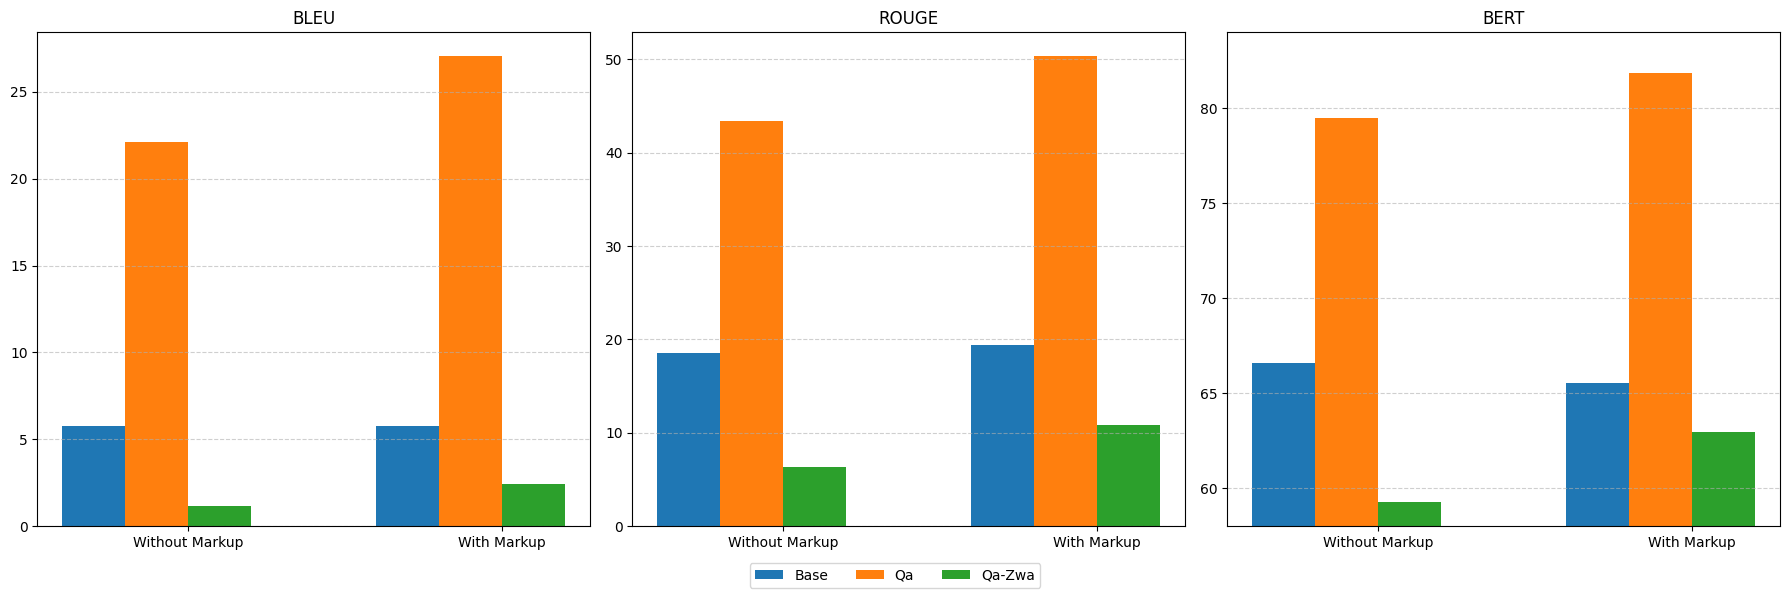

In [45]:
fig = plot_model_metrics_with_ci(mean_df, "8B", bert_ylim=(58, 84))

In [19]:
mean_df, std_df = compare(["gpt-4o-mini", "llama-8B", "llama-70B-base", "llama-8B-qa-Zwa", "llama-70B-qa-Zwa"], "test", "instruct_add")

No evaluation yet for gpt-4o-mini on instruct_add, test
No evaluation yet for llama-8B on instruct_add, test
No evaluation yet for llama-70B-base on instruct_add, test
No evaluation yet for llama-8B-qa-Zwa on instruct_add, test
No evaluation yet for llama-70B-qa-Zwa on instruct_add, test


In [56]:
mean_df, std_df = compare(["llama-8B-base", "gpt-4o-mini"], "test", "instruct_add")
mean_df

,bleu_without,rouge_without,bert_without,bleu_with,rouge_with,bert_with
llama-8B-base,1.791781,6.371774,63.150201,1.989705,8.107051,62.169435
gpt-4o-mini,0.073250,4.900700,59.722872,1.377031,5.335211,58.144823


# looking at the evaluators

## check Rouge function


In [3]:
!pip install bertscore

ERROR: Could not find a version that satisfies the requirement bertscore (from versions: none)
ERROR: No matching distribution found for bertscore


In [29]:
from evaluate_utils import compute_bleu_rouge
pred = """<persName ref="p18988" cert="high">Cyprianus</persName>, De Lapsis, 15, 1; CSEL 3, 56–57."""
ref = """Vgl. bes. <persName ref="p18988" cert="high">Cyprian</persName>, Epist. 63, 10, 2-11, 1 und 14, 1-3 (CChr III C 402f. 408f)."""
tokenizer = XMLTokenizer(pred)
tokenizer.tokenize()


TypeError: tokenize() missing 1 required positional argument: 'xml_string'

In [32]:
pred = """Vgl. Gen 32, 28."""
ref = """Vgl. Gen 35, 10."""
compute_bleu_rouge((pred, ref))

(0.31947155212313627, 0.5)

In [33]:
pred = """Der böhmische Kanzler, der in der Region von Böhmen eine entscheidende Rolle gespielt hat, war ein wichtiger Akteur während der Religionskriege des 16. Jahrhunderts. Das Referenz zu "von Blauwen" könnte sich auf den Adelsgeschlecht von Blau oder ähnlichen Familien beziehen, die in dieser Zeit Einfluss in Böhmen hatten."""
ref = """Heinrich von Plauen, Burggraf von Meißen und böhmischer Kanzler."""
compute_bleu_rouge((pred, ref))

(0.03454447598433573, 0.14285714285714288)

In [1]:
from evaluate import load
pred = """I wanted to do it"""
ref = """I want to do it"""
rouge.compute(predictions=[pred], references=[ref])

ModuleNotFoundError: No module named 'evaluate'

In [ ]:
pred = """<persName ref="p18988" cert="high">Cyprianus</persName>, De Lapsis, 15, 1; CSEL 3, 56–57."""
ref = """Vgl. bes. <persName ref="p18988" cert="high">Cyprian</persName>, Epist. 63, 10, 2-11, 1 und 14, 1-3 (CChr III C 402f. 408f)."""
rouge.compute(predictions=[pred], references=[ref])

{'rouge1': 0.4102564102564102,
 'rouge2': 0.2162162162162162,
 'rougeL': 0.4102564102564102,
 'rougeLsum': 0.4102564102564102}

In [5]:
# The original ROUGE library requires a perl package to be installed. If you try to run the
# setup-metric command and it fails, it's probably because you need to install the perl library
!sudo apt install libxml-dom-perl

[sudo] password for niko: 


In [6]:
!python --version

Python 3.11.5


In [8]:
# Download the original perl code
!sacrerouge setup-metric rouge

Traceback (most recent call last):
  File "/home/niko/anaconda3/bin/sacrerouge", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/home/niko/anaconda3/lib/python3.11/site-packages/sacrerouge/__main__.py", line 5, in main
    parser = build_argument_parser()
             ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/niko/anaconda3/lib/python3.11/site-packages/sacrerouge/arguments.py", line 10, in build_argument_parser
    import_module_and_submodules('sacrerouge')
  File "/home/niko/anaconda3/lib/python3.11/site-packages/sacrerouge/common/util.py", line 102, in import_module_and_submodules
    for module_finder, name, _ in pkgutil.walk_packages(path):
  File "/home/niko/anaconda3/lib/python3.11/pkgutil.py", line 92, in walk_packages
    __import__(info.name)
  File "/home/niko/anaconda3/lib/python3.11/site-packages/datasets/__init__.py", line 33, in <module>
    from .arrow_dataset import Dataset, concatenate_datasets
  File "/home/niko/anaconda3/lib/python3.11/site-packages

In [ ]:
pred = """Vgl. Gen 32, 28."""
ref = """Vgl. Gen 35, 10."""
rouge.compute(predictions=[pred], references=[ref])

{'rouge1': 0.5, 'rouge2': 0.3333333333333333, 'rougeL': 0.5, 'rougeLsum': 0.5}

In [39]:
ref = 'Ruman, der Augsburg am 22. Juli verlassen hatte (s. Nr. 2970,), ist bereits am 28. Juli in Zürich nachgewiesen; s. Nr. 2969,.'
pred = 'blabla was anderes Ruman aber sonst voll was anderseöasldjf ösadlkf öasdlf jaösdflk asödlfkj aöslfd aösdfl jaösdlkf Nr. Zürich im Juli habe ich Augsburg verlassen'
compute_bleu_rouge((pred, ref))

(0.0382756136029561, 0.375)

## check the BLEU funcion

In [2]:
import evaluate
bleu = evaluate.load("bleu")

In [3]:
pred = """Vgl. Gen 32, 28."""
ref = """Vgl. Gen 35, 10."""
bleu.compute(predictions=[pred], references=[ref])

{'bleu': 0.0,
 'precisions': [0.7142857142857143, 0.3333333333333333, 0.2, 0.0],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0,
 'translation_length': 7,
 'reference_length': 7}

In [ ]:
pred = """<persName ref="p18988" cert="high">Cyprianus</persName>, De Lapsis, 15, 1; CSEL 3, 56–57."""
ref = """Vgl. bes. <persName ref="p18988" cert="high">Cyprian</persName>, Epist. 63, 10, 2-11, 1 und 14, 1-3 (CChr III C 402f. 408f)."""
bleu.compute(predictions=[pred], references=[ref])

{'bleu': 0.3071224950142814,
 'precisions': [0.7741935483870968,
  0.5666666666666667,
  0.4827586206896552,
  0.42857142857142855],
 'brevity_penalty': 0.5595372583118381,
 'length_ratio': 0.6326530612244898,
 'translation_length': 31,
 'reference_length': 49}

Bleu is very strict... For example these simple ones, that are quite similar, bc they are all bible refs. But I guess they are too short?

## check Bert score

In [ ]:
pred = """Der böhmische Kanzler, der in der Region von Böhmen eine entscheidende Rolle gespielt hat, war ein wichtiger Akteur während der Religionskriege des 16. Jahrhunderts. Das Referenz zu "von Blauwen" könnte sich auf den Adelsgeschlecht von Blau oder ähnlichen Familien beziehen, die in dieser Zeit Einfluss in Böhmen hatten."""
ref = """Heinrich von Plauen, Burggraf von Meißen und böhmischer Kanzler.."""
bertscore.compute(predictions=[pred], references=[ref], lang="de")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

{'precision': [0.5995287299156189],
 'recall': [0.7128308415412903],
 'f1': [0.6512888073921204],
 'hashcode': 'bert-base-multilingual-cased_L9_no-idf_version=0.3.12(hug_trans=4.44.2)'}

In [ ]:
ref = 'Ruman, der Augsburg am 22. Juli verlassen hatte (s. Nr. 2970,), ist bereits am 28. Juli in Zürich nachgewiesen; s. Nr. 2969,.'
pred = ''
bertscore.compute(predictions=[pred], references=[ref], lang="de")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

{'precision': [0.0],
 'recall': [0.0],
 'f1': [0.0],
 'hashcode': 'bert-base-multilingual-cased_L9_no-idf_version=0.3.12(hug_trans=4.44.2)'}

# Label Eval

In [43]:
# import plt
import matplotlib.pyplot as plt

def label_eval(metric, split, prompt, models):
  """evaluate all the labels, based on a metric"""
  model = models[0]
  df = label_averages(metric, split, prompt, model)

  if len(models) > 1:
    for model in models[1:]:
      new_df = label_averages(metric, split, prompt, model)
      df = pd.concat([df, new_df], axis=1)
  return df

def label_averages(metric, split, prompt, model):
  filename = f"evaluation-{model}_{prompt.replace('_', '-')}_{split.replace('_', '-')}.csv"
  filepath = os.path.join(EVAL_FOLDER, filename)
  if not os.path.exists(filepath):
    raise FileNotFoundError(f"No evaluation yet for {model} on {prompt}, {split}")
  df = pd.read_csv(filepath)
  df = df[["letter_id", "n_footnote", metric, "label"]]

  # split the labels into a list
  df["label"] = df["label"].apply(lambda x: x.replace(" ", "").split(","))
  # explode the labels
  df = df.explode("label")

  # rename metric column to model
  df = df.rename(columns={metric: model})
  # get averages per label, make column with the model name
  return df.groupby("label").mean()[model]

def plot_label_eval(metric, split, prompt, models):
  df = label_eval(metric, split, prompt, models)
  # exclude row where label is "missing"
  df = df[df.index != "missing"]
  # plot the data
  df.plot(kind="bar")
  #set title of the plot
  plt.title(f"{metric} for {prompt} on {split}")
  # set x-axis label
  plt.xlabel("")
  # move the legend next to the graph
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()


# plot_label_eval("rouge_without", "example", "instruct_add", ["llama-instruct-base", "llama-instruct-add", "llama-instruct-qa", "llama-instruct-add-qa"])

In [ ]:
df = (label_averages("rouge_without", "example", "instruct_add", "llama-instruct-base"))
df = df[df.index != "missing"]

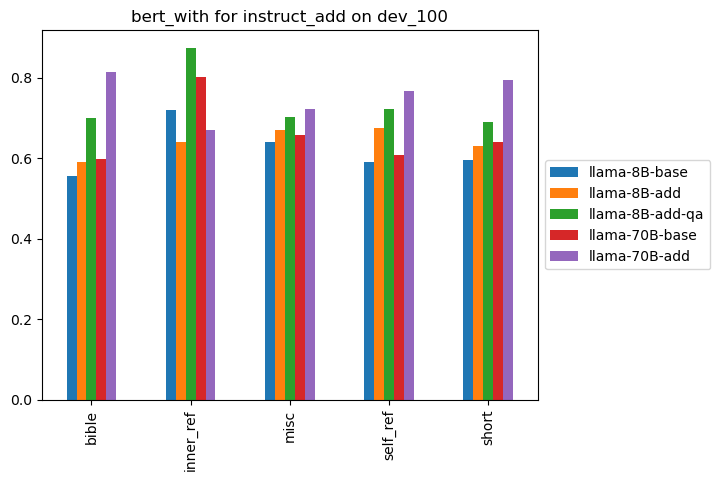

In [47]:
plot_label_eval("bert_with", "dev_100", "instruct_add", ["llama-8B-base", "llama-8B-add", "llama-8B-add-qa", "llama-70B-base", "llama-70B-add"])

In [ ]:
# make a bar chart


# trying to make df to latex table...

In [ ]:
import re


class BestWorstDf():
  def __init__(self, metric, df, n=5):
    self.df = self._create_best_worst_df(df, metric, n)
    # self.df = self._escape_for_latex(self.df)

  def _combine_id_n(self, df):
    """combine id and n_footnote into one, for readability"""

    new_df = df.copy()
    new_df["id-n"] = new_df["letter_id"].astype(str) + "-" + new_df["n_footnote"].astype(str)
    new_df = new_df.drop(["letter_id", "n_footnote"], axis=1)

    # put the new column to the start
    cols = new_df.columns.tolist()
    # Move the desired column to the beginning
    cols.insert(0, cols.pop(cols.index('id-n')))
    # Reorder the DataFrame columns
    new_df = new_df[cols]
    return new_df

  def _escape_for_latex(self, df):
    new_df = df.rename(columns=lambda x: escape_latex(x))  # Apply escape_latex to column names
    new_df = escape_latex_for_df(new_df)  # Apply escape_latex to dataframe content
    return new_df

  def _create_best_worst_df(self, df, metric, n):
    best_worst_df = df.sort_values(by=metric, ascending=False)
    best_worst_df = pd.concat([best_worst_df.head(5), best_worst_df.tail(5)])

    # drop data columns that are not the metric
    drop_cols = []
    for col in best_worst_df.columns:
      if str(best_worst_df[col].dtype) == "float64" and col != metric:
        drop_cols.append(col)
    best_worst_df = best_worst_df.drop(drop_cols, axis=1)
    return best_worst_df

    return best_worst_df

  def print_latex_table(self):
    new_df = self._combine_id_n(self.df)
    new_df = self._escape_for_latex(new_df)
    # round the floats to two decimal points
    for col in new_df.columns:
      if str(new_df[col].dtype) == "float64":
        new_df[col] = new_df[col].round(2)

    # create the format:
    col_format = ""
    for col in new_df.columns:
      if str(new_df[col].dtype) == "object":
        col_format += "X"
      else:
        col_format += "c"

    table_string = (new_df.to_latex(index=False, escape=False, column_format=col_format, float_format="%.2f"))
    # add tabularx package
    table_string = table_string.replace(r"\begin{tabular}", r"\begin{tabularx}{\textwidth}")
    table_string = table_string.replace(r"\end{tabular}", r"\end{tabularx}")
    print(table_string)

def escape_latex(text):
    """Escapes special LaTeX characters in a string."""
    latex_special_chars = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(key) for key in latex_special_chars.keys()))
    return regex.sub(lambda match: latex_special_chars[match.group(0)], text)

def escape_latex_for_df(df):
    """Escapes special LaTeX characters in a dataframe."""
    for col in df.select_dtypes(include=['object']).columns:  # Apply only to string columns
        df[col] = df[col].apply(lambda x: escape_latex(str(x)) if pd.notna(x) else x)
    return df

def make_latex_table_from_df(df):
  new_df = df.rename(columns=lambda x: escape_latex(x))  # Apply escape_latex to column names
  new_df = escape_latex_for_df(new_df)  # Apply escape_latex to dataframe content
  new_df.rename(columns={"n_footnote":"n"})

    # Calculate the desired column width
  total_width = 0.95  # Adjust as needed for the desired table width relative to page width
  num_cols = len(new_df.columns)
  col_width = total_width / num_cols

  # Generate the column format string
  col_format = "llp{4cm}p{4cm}cc"

  # Convert to LaTeX with automatic text wrapping
  print(new_df.to_latex(index=False, escape=False, column_format=col_format))

  # print(new_df.to_latex(index=False, escape=False))
